In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from pandas_datareader import data, wb
import pandas as pd
import datetime as dt
import matplotlib as mpl
import statsmodels as sm
import statsmodels.stats.diagnostic
import statsmodels.tsa
import statsmodels.graphics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

plt.style.use('ggplot')

In [2]:
# np.set_printoptions(precision=3)
# np.set_printoptions(suppress=True)

# <font face="gotham" color="purple"> Stochastic Processes and Stationarity </font> 

Loosely speaking, the **stochastic process** is a branch of mathematics that studies a family of random variables which are indexed by time. And time series data is a series of **realization** of a stochastic process. 

The **stationarity** is a general concept to describe a stochastic process or a time series.

For instance, we denote $\text{GDP}$ as $Y_t$ which is a stochastic process, however the indexed $Y_1$ and $Y_2$ are two different random variables. E.g. $Y_1 = 12345$, it means a realization at period $1$. 

A time series $\{r_t\}$ is _weakly stationary_, if $E(r_t)= \mu$ and $\text{Cov}(r_t, r_{t-k})= \gamma_k$, where $k$ is the number of lag.

This property tells that the mean and the variance are _time-invariant_.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
  <h3>Why do we care about <i>stationarity</i>? </h3>
<p>If a time series is nonstationary, we can only study the behavior in a particular episode and whatever conclusion we draw from the available sample can't be generalized to other episodes. Therefore forecasting nonstationary time series would absolutely be of little value. </p>
</div> 

Most of economic and financial time series are non-stationary, however they are usually weakly stationary at the first difference, such as log return.

Next we will refresh the methods for testing stationarity, first let's load $\text{EURUSD}$ daily series

In [44]:
df.join(np.log(df).add_suffix('_log'))

Symbols,EURUSD=X,EURUSD=X_log
Date,,
2003-12-01,1.196501,0.179402
2003-12-02,1.208897,0.189709
2003-12-03,1.212298,0.192517
2003-12-04,1.208094,0.189044
2003-12-05,1.218695,0.197780
...,...,...
2022-09-29,0.982956,-0.017191
2022-10-02,0.979269,-0.020949
2022-10-03,0.983207,-0.016936


In [47]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.today()
df = data.DataReader(['EURUSD=X'], 'yahoo', start, end)['Close'] # pick close price
df = df.join(np.log(df).add_suffix('_log'))
df.columns = ['EURUSD', 'EURUSD_log']

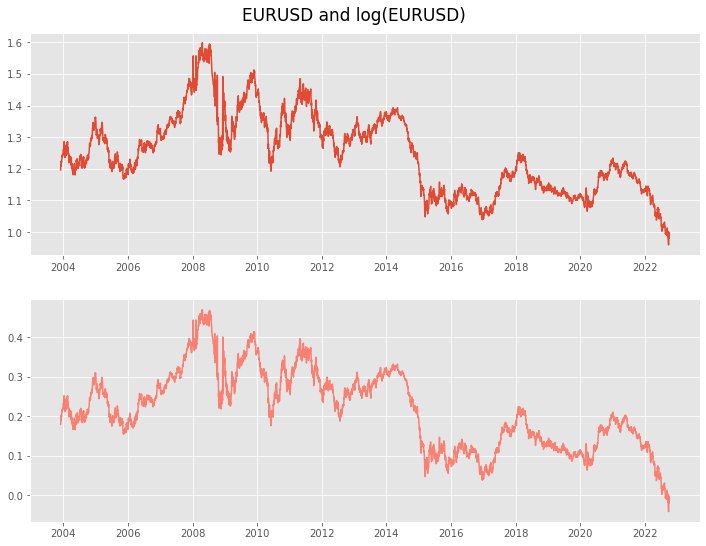

In [57]:
fig, ax = plt.subplots(figsize=(12, 9), ncols=1, nrows=2)
ax[0].plot(df['EURUSD'])
ax[1].plot(df['EURUSD_log'], color='salmon')
plt.suptitle('EURUSD and log(EURUSD)', y=.92, size=17)
plt.show()

## <font face="gotham" color="purple"> Dickey–Fuller (DF) test </font>

The default stationarity test is **Dickey-Fuller** (DF) test.

If we suspect that $Y_t$ follows a unit root process, it would be tempting to simply regress $Y_t$ onto $Y_{t-1}$, i.e. 
$$
Y_{t}=\rho Y_{t-1}+u_{t} \quad-1 \leq \rho \leq 1
$$
and hoping $\rho=1$. In practice, we estimate another form of it.

Some manipulation can bring in more insights
\begin{aligned}
Y_{t}-Y_{t-1} &=\rho Y_{t-1}-Y_{t-1}+u_{t} \\
&=(\rho-1) Y_{t-1}+u_{t}\\
\Delta Y_t &= \delta Y_{t-1}+u_{t}
\end{aligned}
where $\delta = \rho-1$. If $\delta =0$, i.e. $\rho=1$, then $\Delta Y_t = u_t$, therefore $Y_t$ is unstationary; if $\delta <0$, then $\rho <1$, in that case $Y_t$ is stationary.

The last equation $\Delta Y_t = \delta Y_{t-1}+u_{t}$ is the one to estimate for unit root and hypotheses are 
$$
H_0: \delta = 0, \text{unstationary}\\
H_1: \delta < 0, \text{stationary}
$$

It turns out the $t$-statistic calculated on $\delta$ doesn't really follow a $t$-distribution, it actually follows $\tau$-distribution or **Dickey-Fuller distribution**, therefore we call it _Dickey-Fuller test_.

The function has been imported at the top of this notebook, however we still need to customize the output for easy access. ```adf_test``` has been documented in ```tseries_func.py``` as well.

In [72]:
def adf_test(x):
    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]
    
    adf_results_all = adfuller(x, autolag="AIC")
    results = pd.Series(adf_results_all[0:4], index=indices)
    
    for key, value in adf_results_all[4].items():
        results['Critical Value ({})'.format(key)] = value
    results = pd.DataFrame(results, columns = ['statistics'])
    return pd.DataFrame(results)

In [73]:
adf_test(df['EURUSD_log'])

,statistics
Test Statistic,-1.344442
p-value,0.608603
# of Lags Used,31.000000
# of Observations Used,4858.000000
Critical Value (1%),-3.431697
Critical Value (5%),-2.862135
Critical Value (10%),-2.567087


# <font face="gotham" color="purple"> Autocorrelation Function (ACF) </font> 

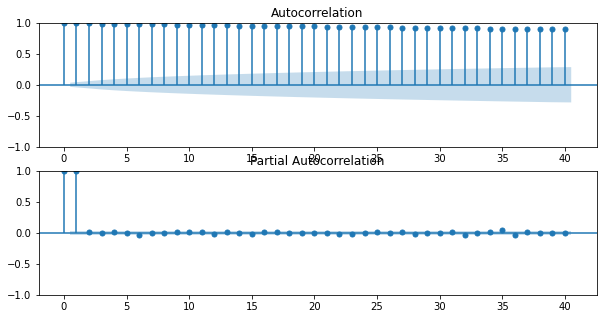

<Figure size 720x360 with 0 Axes>

In [25]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1)
plt.figure()
g2 = plot_acf(df['EURUSD=X'], ax=ax[0], lags=N_LAGS,
         alpha=SIGNIFICANCE_LEVEL)
g1 = plot_pacf(df["EURUSD=X"], ax=ax[1], lags=N_LAGS, method = 'ywm',
          alpha=SIGNIFICANCE_LEVEL)
plt.subplots_adjust(hspace=.6)
plt.show()

The autocorrelation of $r_t$ is commonly denoted by $\rho_k$, which is a function of $k$ alone.

$$
\rho_{k}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\sqrt{\operatorname{Var}\left(r_{t}\right) \operatorname{Var}\left(r_{t-k}\right)}}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\operatorname{Var}\left(r_{t}\right)}=\frac{\gamma_{k}}{\gamma_{0}}
$$

The sample autocorrelation of $r_t$ with lag-$k$ is

$$
\hat{\rho}_{k}=\frac{\sum_{t=k+1}^{T}\left(r_{t}-\bar{r}\right)\left(r_{t-k}-\bar{r}\right)}{\sum_{t=1}^{T}\left(r_{t}-\bar{r}\right)^{2}}, \quad 0 \leq k<T-1
$$

The fastest way to visual autocorrelation is to plot a correlogram, which is basically a ACF.If the data is randomly distributed, the ACF should be near zero for all lags. ```statsmodels.graphics.tsaplots.plot_acf``` from statsmodels library is recommended for the plot.

We will generate a series of uniformly distributed data and plot the ACF.

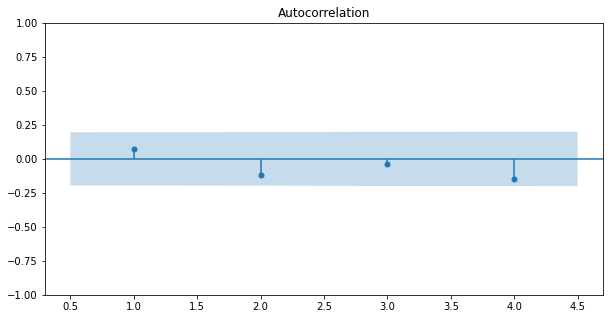

In [6]:
n = 100
series = pd.Series(np.random.rand(n))
k = np.log(n)
mpl.rc('figure', figsize=(10,5))
sm.graphics.tsaplots.plot_acf(series, lags = k, alpha=.05, zero = 0)
plt.show()

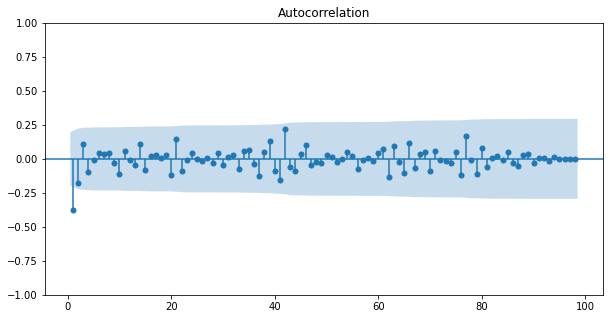

In [7]:
series_log_return = np.log(series) - np.log(series.shift(1))
k = len(series_log_return.dropna())-1
sm.graphics.tsaplots.plot_acf(series_log_return.dropna(),lags = k, alpha=.05, zero = 0) # zero means not including 0 lag
plt.show()

Download Alcoa stock price from Yahoo, plot the log return.

In [8]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()
AA = data.DataReader('AA', 'yahoo', start, end) # AA is the ticker for Alcoa in NYSE
AA_c = AA['Adj Close']

In [9]:
AA_log_return = np.log(AA_c) - np.log(AA_c.shift(1))

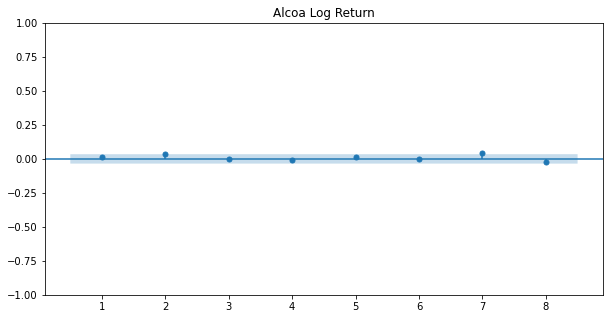

In [10]:
lags= int(np.log(len(AA_log_return)))
sm.graphics.tsaplots.plot_acf(AA_log_return.dropna(), lags = lags, alpha=.05, 
                  title = 'Alcoa Log Return', zero = 0)
plt.show()

Or we can use pandas built-in ```pd.plotting.autocorrelation_plot()``` for correlogram.The downside is that you set the number of lags.

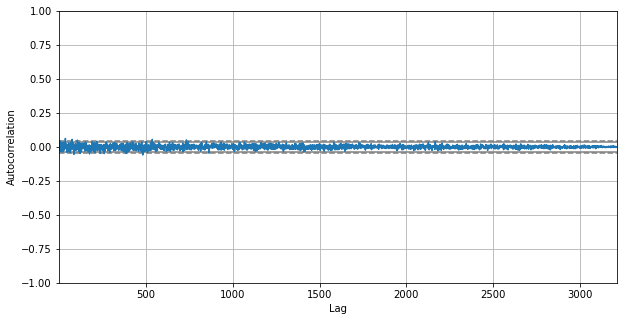

In [11]:
pd.plotting.autocorrelation_plot(AA_log_return.dropna()); plt.show()

We can see that ACF is within the $5\%$ confidence interval, that means the correlation with specific lag is not significantly different than $0$.

# <font face="gotham" color="purple"> Portmanteau Test </font> 

Before modelling a times series, we should check if it is worthy of modelling and also test the residual if it is serial correlated. It is often done by using Portmanteau test.

There are two Portmanteau tests, Ljung-Box test and Box-Pierce Test for this practice.

The statistics are constructed as below
$$
Q^{*}(m)=T \sum_{k=1}^{m} \hat{\rho}_{k}^{2} \tag{Box-Pierce}\\
$$
$$
Q(m)=T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_{k}^{2}}{T-k}\tag{Ljung-Box}
$$

where $m\approx \ln( T)$, is the degree of freedom, for $Q$-statistic. And $Q$-statistic converges to $\chi^2(m)$.

The null and alternative hypotheses are

\begin{align}
H_0&: \rho_{1}=\cdots=\rho_{m}=0\\
H_{a}&: \rho_{i} \neq 0
\end{align}

In [12]:
lags= int(np.log(len(AA_log_return)))
sm.stats.diagnostic.acorr_ljungbox(AA_log_return.dropna(),boxpierce=True, lags= lags)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.536295,0.463972,0.535794,0.464181
2,5.496716,0.064033,5.490040,0.064247
3,5.497412,0.138794,5.490734,0.139194
4,5.837662,0.211604,5.830349,0.212181
5,6.622671,0.250249,6.613648,0.250995
6,6.645748,0.354853,6.636668,0.355758
7,13.019308,0.071639,12.992375,0.072294
8,15.270488,0.054095,15.236548,0.054706


The first two rows of results are Ljung-Box statistics and p-value, and the last two rows are from Box-Pierce test. For both tests, we fail to reject null hypothesis.

Zero autocorrelation has been used as a tool for checking EMH.

## <font face="gotham" color="purple"> The Autocorrelation of S&P 500  </font> 

In [13]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()
SP500 = data.DataReader('^GSPC', 'yahoo', start, end) # AA is the ticker for Alcoa in NYSE
SP500_c = SP500['Close']

Change the frequency to month.

In [14]:
SP500_c = SP500_c.asfreq(freq = 'M', method= 'pad'); SP500_c

Date
2010-01-31    1073.869995
2010-02-28    1104.489990
2010-03-31    1169.430054
2010-04-30    1186.689941
2010-05-31    1089.410034
                 ...     
2022-05-31    4132.149902
2022-06-30    3785.379883
2022-07-31    4130.290039
2022-08-31    3955.000000
2022-09-30    3585.620117
Freq: M, Name: Close, Length: 153, dtype: float64

Calculate the log return.

In [15]:
SP500_log_return = np.log(SP500_c) - np.log(SP500_c.shift(1))

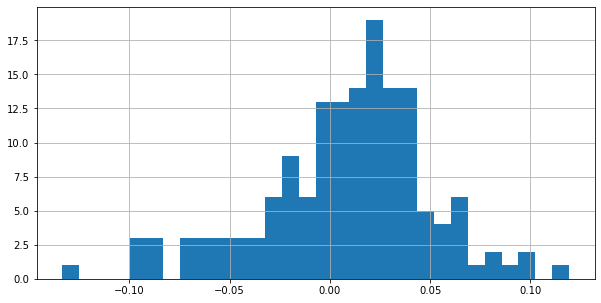

In [16]:
SP500_log_return.hist(bins = 30); plt.show()

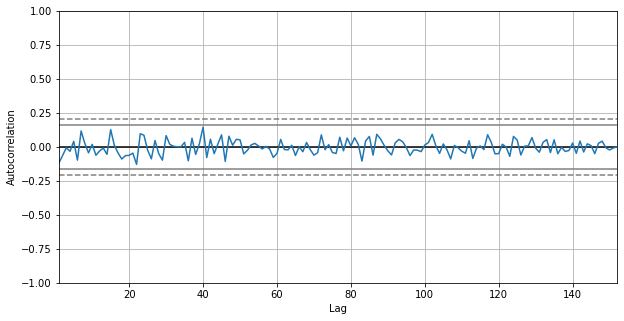

In [17]:
pd.plotting.autocorrelation_plot(SP500_log_return.dropna()); plt.show()

In [18]:
lags= int(np.log(len(SP500_log_return)))
sm.stats.diagnostic.acorr_ljungbox(SP500_log_return.dropna(),boxpierce=True, lags= lags)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.159996,0.141645,2.117918,0.145584
2,2.766326,0.250784,2.708500,0.258141
3,2.772141,0.428107,2.714125,0.437832
4,2.939477,0.568004,2.874942,0.578967
5,3.208420,0.667889,3.131660,0.679696


## <font face="gotham" color="purple"> White Noise </font> 